# AdaptiveTracking_2021

- **Paper**: An Adaptive Tracking Algorithm for Convection in Simulated and Remote Sensing Data

- $\textbf{\textcolor{red}{Identification}}$:
    - **Identification**: no new technique

    - **Representation**: estimate by Ellipse with geometric mean centroid instead of weighted mean.

- $\textbf{\textcolor{blue}{Tracking}}$:
    - **Flow region**: a squared area around each storm 
        $$side = object \ length + buffer$$
        After searching, we gain an estimated vector.

    - **Corrected shift**: uses both *estimated shift* vs *recorded motion*:
        + If 2 differs too much $\Rightarrow$ use *recorded motion*.
        + If not, take the mean of them.

    - **Search region**: the predicted window of the current storm.

    - **Candidates**: storms which are partially or entirely located in search region.

    - **Disparity matrix**: cost between candidate-target, disparity $D$ has 2 elements:
            $$D = d_c + d_p + \sqrt{a_c} - \sqrt{a_0}$$
        + $d_c = \operatorname{dist(cand\_center, targ\_center)}$
        + $d_p = \operatorname{dist(cand\_center, pred\_center)}$
        + $a_c$ = area difference between 2 storms
        + $a_o$ = area overlapping between 2 storms.
        
    - **Hungarian matching**: 
        + assign 1-to-1 mapping
        + after assignment, check if D>=45km/hr => cancel
        + not matched prev storm => expired
        + not matched curr storm => initiated

    - **Split & merge**:
        + *split*: new storm ovelaps with prev obj. The obj with least disparity carries the UID of the parent.
        + *merge*: expired storm overlaps with current storm. The resulting storm receives the UID of the previous matching storm.

- $\textbf{\textcolor{yellow}{Nowcasting}}$:
    + Not mentioned, hence applied the linear interpolation as the previous.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [4]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

SOURCE_PATH = "data/images/philippines_13.269_123.832"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:40]
img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

Number of frames: 40


## 1, Identification

- Implement class `CentroidStorm` which stores the information about its contour shape, and its centroid.

In [ ]:
from src.identification import MorphContourIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from shapely.geometry import Polygon
from skimage.registration import phase_cross_correlation

class CentroidStorm(StormObject):
    centroid: np.ndarray
    estimated_velocity: tuple[float, float] = None  # estimated movement for the current storm in the next frame

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], id: str=""):
        super().__init__(polygon, id)
        self.centroid = np.array(centroid)

class DbzStormsMap(StormsMap):
    storms: list[CentroidStorm]
    dbz_map: np.ndarray

    def __init__(self, storms: list[CentroidStorm], time_frame: datetime, dbz_map: np.ndarray):
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
        self.dbz_map = dbz_map
    
    def fft_estimate(self, other: "DbzStormsMap", max_velocity: float):
        """
        Estimate the movement for each storm in the current map.
        Return the square, surrounding regions without buffer for each storm.
        """
        H, W = self.dbz_map.shape
        dt = (other.time_frame - self.time_frame).total_seconds() / 3600.0  # in hours
        max_displacement = max_velocity * dt
        buffer = int(max_displacement) + 5          # compute the buffer

        region_list = []
    
        for storm in self.storms:
            min_x, min_y, max_x, max_y = storm.contour.bounds
            y_len = max_y - min_y
            x_len = max_x - min_x
            if y_len < x_len:
                min_y = max(min_y - ((x_len - y_len) // 2), 0)
                max_y = min(max_y + ((x_len - y_len) // 2), H)
                min_x = max(min_x, 0)
                max_x = min(max_x, W)
            else:
                min_x = max(min_x - ((y_len - x_len) // 2), 0)
                max_x = min(max_x + ((y_len - x_len) // 2), W)
                min_y = max(min_y, 0)
                max_y = min(max_y, H)

            # store the region without buffer
            region_list.append((min_y, max_y, min_x, max_x))

            # add buffer to the search region
            min_x = max(min_x - buffer, 0)
            max_x = min(max_x + buffer, W)
            min_y = max(min_y - buffer, 0)
            max_y = min(max_y + buffer, H)

            # get the search regions
            prev_region = self.dbz_map[int(min_y):int(max_y), int(min_x):int(max_x)]
            curr_region = other.dbz_map[int(min_y):int(max_y), int(min_x):int(max_x)]

            # normalize regions
            prev_region = prev_region - np.mean(prev_region)
            curr_region = curr_region - np.mean(curr_region)

            # compute shift via FFT
            shift, error, diffphase = phase_cross_correlation(curr_region, prev_region, upsample_factor=10)
            dy, dx = shift

            # truncate the large shift
            if np.linalg.norm(shift) > max_displacement:
                scale_factor = max_displacement / np.linalg.norm(shift)
                dy *= scale_factor
                dx *= scale_factor

            storm.estimated_velocity = (dy / dt, dx / dt)  # in pixels / hour

        return region_list

In [6]:
THRESHOLD = 35
FILTER_AREA = 20    # storm with area under this threshold => cancel

Processing images and detecting storms: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 12
Time: 2025-01-08 03:16:44 | Detected storms: 13
Time: 2025-01-08 03:22:45 | Detected storms: 17
Time: 2025-01-08 03:28:45 | Detected storms: 12
Time: 2025-01-08 03:34:45 | Detected storms: 12
Time: 2025-01-08 03:40:45 | Detected storms: 14
Time: 2025-01-08 03:46:46 | Detected storms: 14
Time: 2025-01-08 03:52:46 | Detected storms: 13
Time: 2025-01-08 03:58:46 | Detected storms: 12
Time: 2025-01-08 04:04:46 | Detected storms: 14
Time: 2025-01-08 04:10:47 | Detected storms: 13
Time: 2025-01-08 04:16:47 | Detected storms: 14
Time: 2025-01-08 04:22:47 | Detected storms: 23
Time: 2025-01-08 04:28:47 | Detected storms: 15
Time: 2025-01-08 04:34:48 | Detected storms: 15
Time: 2025-01-08 04:40:48 | Detected storms: 11
Time: 2025-01-08 04:46:48 | Detected storms: 9
Time: 2025-01-08 04:52:48 | Detected storms: 17
Time: 2025-01-08 04:58:49 | Detected storms: 15
Time: 2025-01-08 05:04:49 | Detected storms: 14
Time: 2025-01-08 05:

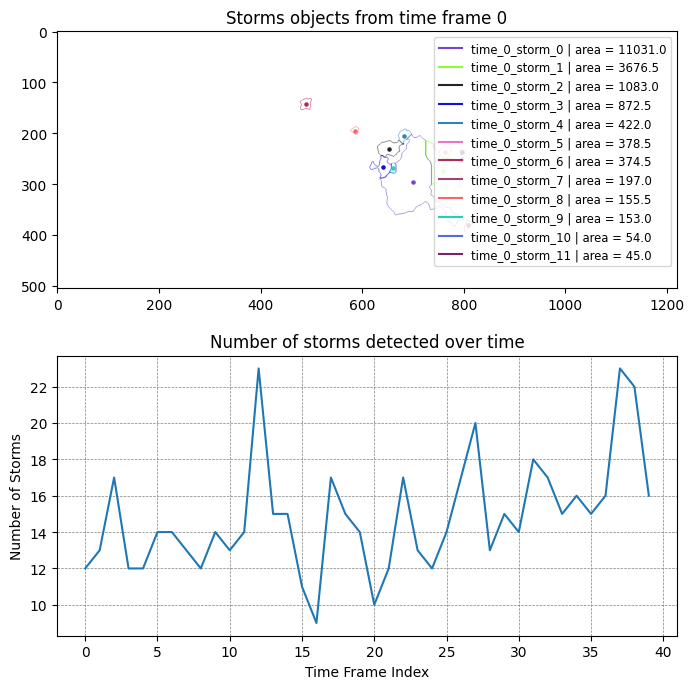

In [8]:
identifier = MorphContourIdentifier(n_thresh=3, threshold=THRESHOLD, filter_area=FILTER_AREA)
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute the geometric centroid instead of weighted centroid
        centroid = polygon.centroid.coords[0]

        storms.append(CentroidStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}"
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame, dbz_map=dbz_map)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    # x_centroid, y_centroid = storm.contour.centroid.x, storm.contour.centroid.y
    x_centroid, y_centroid = storm.centroid
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')
plt.legend(loc="upper right", fontsize='small', ncol=1)


plt.subplot(2,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

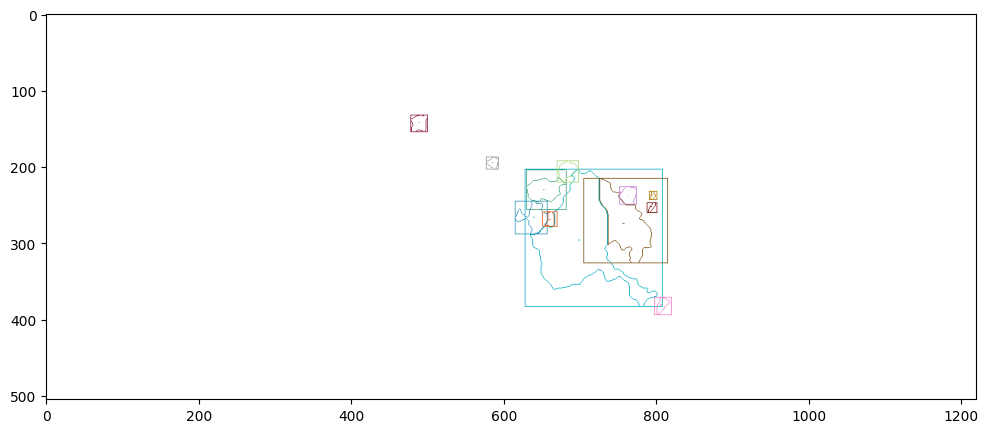

In [9]:
MAX_VELOCITY = 500
prev_storms_map = storms_map_time_lst[0]
curr_storms_map = storms_map_time_lst[1]

dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).total_seconds() / 3600.0  # in hours

search_region_list = prev_storms_map.fft_estimate(curr_storms_map, max_velocity=MAX_VELOCITY)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255
for storm, (min_y, max_y, min_x, max_x) in zip(prev_storms_map.storms, search_region_list):
    color = np.random.randint(0, 255, size=3).tolist()
    contours = convert_polygons_to_contours([storm.contour])
    cv2.drawContours(blank_image, contours, -1, color, thickness=1)
    cv2.rectangle(blank_image, (int(min_x), int(min_y)), (int(max_x), int(max_y)), color, thickness=1)

    dy, dx = storm.estimated_velocity
    x_centroid, y_centroid = storm.centroid
    new_y = y_centroid + dy * dt
    new_x = x_centroid + dx * dt

    cv2.line(blank_image, (int(x_centroid), int(y_centroid)), (int(new_x), int(new_y)), color, thickness=1)

plt.figure(figsize=(12, 12))
plt.imshow(blank_image)
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Disparity matrix**: cost between candidate-target, $D$ has 2 elements:
        $$D = d_c + d_p + \sqrt{a_c} - \sqrt{a_0}$$
    + $d_c = \operatorname{dist(cand\_center, \ targ\_center)}$
    + $d_p = \operatorname{dist(cand\_center, \ pred\_center)}$
    + $a_c$ = area difference between 2 storms
    + $a_o$ = area overlapping between 2 storms.

In [10]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker
from typing import Callable
from shapely.affinity import translate
from shapely.geometry import box

class Matcher(BaseMatcher):
    max_velocity: float
    max_velocity_diff: float

    def __init__(self, max_velocity: float, max_velocity_diff: float, max_cost: float):
        self.max_velocity = max_velocity            # maximum allowed velocity (pixels/hour) for truncation
        self.max_velocity_diff = max_velocity_diff  # maximum difference between historical and estimated velocity
        self.max_cost = max_cost                    # maximum cost for cost matrix

    def _construct_disparity_matrix(
            self, storm_lst1: list[CentroidStorm], storm_lst2: list[CentroidStorm], 
            shifts: np.ndarray
        ) -> np.ndarray:
        """
        Construct a disparity matrix based on centroids estimated from FFT.

        Args:
            storm_lst1 (list[CentroidStorm]): List of storms in previous time (target of matching).
            storm_lst2 (list[CentroidStorm]): List of storms in current time (candidate for matching).
            estimated_displacements (list[np.ndarray]): Estimated displacements for each storm in storm_lst1.
        
        Returns:
            np.ndarray: Disparity matrix.
        """
        targ_centroids = np.array([storm.centroid for storm in storm_lst1])
        cand_centroids = np.array([storm.centroid for storm in storm_lst2])
        pred_center = targ_centroids + shifts

        d_c = np.linalg.norm(
            targ_centroids[:, np.newaxis, :] - cand_centroids[np.newaxis, :, :], axis=-1
        )   # shape: (num_targ, num_cand)
        
        d_p = np.linalg.norm(
            pred_center[:, np.newaxis, :] - cand_centroids[np.newaxis, :, :], axis=-1
        )   # shape: (num_targ, num_cand)
        
        a_c = np.abs(
            np.array([storm.contour.area for storm in storm_lst1])[:, np.newaxis] - 
            np.array([storm.contour.area for storm in storm_lst2])[np.newaxis, :]
        )   # shape: (num_targ, num_cand)

        a_o = np.array([
            prev_storm.contour.intersection(curr_storm.contour).area
            for prev_storm in storm_lst1
            for curr_storm in storm_lst2
        ]).reshape(len(storm_lst1), len(storm_lst2))

        return np.clip(d_c + d_p + np.sqrt(a_c) - np.sqrt(a_o), 0, None)
    
    def _process_velocity(self, history_velocity: np.ndarray, estimated_velocity: np.ndarray) -> np.ndarray:
        """
        Process the velocity by combining historical and estimated velocities of a storm.

        Args:
            history_velocity (np.ndarray): Historical velocity of the storm.
            estimated_velocity (np.ndarray): Estimated velocity from FFT.

        Returns:
            np.ndarray: corrected velocity.
        """
        if history_velocity is None:
            return estimated_velocity
        elif np.linalg.norm(history_velocity - estimated_velocity) > self.max_velocity_diff:
            return estimated_velocity
        
        return 0.5 * (history_velocity + estimated_velocity)

    def match_storms(
            self, storms_map_1: DbzStormsMap, storms_map_2: DbzStormsMap, history_velocities: list[np.ndarray]
        ) -> tuple[np.ndarray, np.ndarray]:
        """
        Match storms between 2 time frames.

        Args:
            storms_map_1 (DbzStormsMap): Previous storms map.
            storms_map_2 (DbzStormsMap): Current storms map.
            history_velocities (list[np.ndarray]): Previously recorded velocities for storms in storms_map_1.
        
        Returns:
            tuple[np.ndarray, np.ndarray]: 
                + matched indices (N x 2) where N is the number of matched storm pairs.
                + cost matrix (num_storms_1 x num_storms_2).
        """
        # region_list (list[min_y, min_x, max_y, max_x]): regions for each storm without the buffer
        region_list = storms_map_1.fft_estimate(storms_map_2, max_velocity=self.max_velocity)
        dt = (storms_map_2.time_frame - storms_map_1.time_frame).total_seconds() / 3600.0  # in hours
        max_displacement = self.max_velocity * dt

        # Step 1: Retrieve displacements
        estimated_velocities = [
            np.array(storm.estimated_velocity) for storm in storms_map_1.storms
        ]

        corrected_shifts = np.array([
            self._process_velocity(history_velocity, estimated_velocity) * dt
            for history_velocity, estimated_velocity in zip(history_velocities, estimated_velocities)
        ])

        # step 2: Retrieve search regions = original regions + corrected shifts
        H, W = storms_map_1.dbz_map.shape
        regions = np.array(region_list)
        y_regions = regions[:, :2]
        x_regions = regions[:, 2:]
        y_search_regions = np.clip(y_regions + corrected_shifts[:, 0][:, np.newaxis], 0, H)
        x_search_regions = np.clip(x_regions + corrected_shifts[:, 1][:, np.newaxis], 0, W)

        search_regions = np.concatenate([y_search_regions, x_search_regions], axis=-1)

        # Step 3: Construct disparity matrix
        cost_matrix = self._construct_disparity_matrix(
            storms_map_1.storms,
            storms_map_2.storms,
            corrected_shifts
        )

        # step 3: Mark the valid matches => curr storm in the search region of previous storm
        valid_mask = np.zeros_like(cost_matrix, dtype=bool)

        for i in range(len(storms_map_1.storms)):
            min_y, max_y, min_x, max_x = search_regions[i]
            search_box = box(min_x, min_y, max_x, max_y)
            for j, storm in enumerate(storms_map_2.storms):
                if cost_matrix[i, j] > self.max_cost:
                    continue
                curr_pol = storm.contour
                # intersect a part or whole => valid
                if search_box.intersection(curr_pol).area > 0:
                    valid_mask[i, j] = True

        # step 4: Invalidate the invalid matches
        invalid_mask = ~valid_mask
        cost_matrix[invalid_mask] = 5000.0   # large cost for invalid matches

        # step 5: Find the optimal matching
        row_ind, col_ind = self._hungarian_matching(cost_matrix)

        assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        return np.argwhere(assignment_mask & valid_mask), cost_matrix

### 2.2 Implementation of `TrackingHistory`

- **Idea**: keep track of storms evolution over time.

- **Public methods**:
    - $\textcolor{yellow}{\text{forecast}}$: forecast the next position of current storm track.
    - $\textcolor{yellow}{\text{update}}$: receive the mapping of current storms and update the track.

In [14]:
from copy import deepcopy
from shapely import Polygon
from shapely.affinity import translate
from dataclasses import dataclass

@dataclass
class Correspondence:
    prev_indices: list[int]
    curr_indices: list[int]

class TrackingHistory(BaseTrackingHistory):
    def __init__(self, storms_map: StormsMap):
        self.tracks = [self._initialize_track(storm, storms_map.time_frame) for storm in storms_map.storms]
        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
    
    def _initialize_track(self, storm: CentroidStorm, time_frame: datetime):
        return {"storm_lst": [storm], "frame": [time_frame], "movement": []}
    
    def _get_track(self, storm_id: str) -> tuple[dict, float]:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple(dict, float))
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm {storm_id} not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id], track_id in self.active_list

    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5):
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)

    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> CentroidStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track, is_active = self._get_track(storm_id)
        if not is_active:
            print(f"⚠️ Storm has been expired")
            
        curr_storm = track["storm_lst"][-1]

        velocity_lst = track["movement"]
        if len(velocity_lst) == 0:      # if no recorded velocity => use the default motion.
            velocity_lst = [default_motion]
        
        dx, dy = self._interpolate_velocity(velocity_lst) * dt
        new_pol = translate(curr_storm.contour, xoff=dx, yoff=dy)
        new_centroid = curr_storm.centroid + np.array(dx, dy)

        return CentroidStorm(new_pol, centroid=new_centroid)
    
    def get_history_velocities(self, storm_lst: list[CentroidStorm]) -> list[np.ndarray]:
        """
        Get the historical velocities for the given storm list.

        Args:
            storm_lst (list[CentroidStorm]): List of storms to get historical velocities.
        Returns:
            list[np.ndarray]: List of historical velocities.
        """
        history_velocities = []
        for storm in storm_lst:
            track, _ = self._get_track(storm.id)
            if len(track["movement"]) == 0:
                history_velocities.append(None)
            else:
                history_velocities.append(np.array(self._interpolate_velocity(track["movement"])))
        return history_velocities

    def update(self, correspondence_lst: list[Correspondence], prev_storms_map: StormsMap, curr_storms_map: StormsMap):
        active_lst = []
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def get_movement(prev_idx, curr_idx):
            """
            Get the centroid movement of 2 storms, scaled to pixel/hr.
            """
            return (curr_storms_map.storms[curr_idx].centroid - prev_storms_map.storms[prev_idx].centroid) / dt
        
        for corr in correspondence_lst:
            # case 1: new storm
            if len(corr.prev_indices) == 0:
                curr_storm = curr_storms_map.storms[corr.curr_indices[0]]
                # create a new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))
                new_uid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_uid
                active_lst.append(new_uid)
            
            # case 2: only one curr storm
            elif len(corr.curr_indices) == 1:
                curr_storm = curr_storms_map.storms[corr.curr_indices[0]]
                prev_idx = corr.prev_indices[0]
                prev_storm = prev_storms_map.storms[prev_idx]
                track_id = self.storm_dict[prev_storm.id]
                track = self.tracks[track_id]
                track["storm_lst"].append(curr_storm)
                track["frame"].append(curr_time)
                track["movement"].append(get_movement(prev_idx, corr.curr_indices[0]))
                self.storm_dict[curr_storm.id] = track_id
                active_lst.append(track_id)
            
            # case 3: more than one curr storm => split
            else:
                # assign the UID of the parent to the child with least disparity (1st curr storm)
                prev_idx = corr.prev_indices[0]
                prev_storm = prev_storms_map.storms[prev_idx]
                
                ## resolve last track carry
                first_curr_idx = corr.curr_indices[0]
                curr_storm = curr_storms_map.storms[first_curr_idx]

                track_id = self.storm_dict[prev_storm.id]
                track = self.tracks[track_id]
                track["storm_lst"].append(curr_storm)
                track["frame"].append(curr_time)
                track["movement"].append(get_movement(prev_idx, first_curr_idx))
                self.storm_dict[curr_storm.id] = track_id
                active_lst.append(track_id)

                ## resolve new tracks for the rest
                for curr_idx in corr.curr_indices[1:]:
                    curr_storm = curr_storms_map.storms[curr_idx]
                    # create a new track
                    self.tracks.append(self._initialize_track(curr_storm, curr_time))
                    new_uid = len(self.tracks) - 1
                    self.storm_dict[curr_storm.id] = new_uid
                    active_lst.append(new_uid)
        
        self.active_list = active_lst

    def print_tracks(self, active_only: bool = False):
        for id, track in enumerate(self.tracks):
            if active_only and id not in self.active_list:
                continue
            print(f"Track {id:2d}. " + " -> ".join(storm.id for storm in track["storm_lst"]))
            print(f"Lifespan: {len(track['frame'])}")
            print(f"Last track: {track['frame'][-1].strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

- **Split & merge**:
    + $\textcolor{cyan}{\text{split}}$: new storm ovelaps with prev obj. The obj with least disparity carries the UID of the parent.
    + $\textcolor{cyan}{\text{merge}}$: expired storm overlaps with current storm. The resulting storm receives the UID of the previous matching storm.

In [15]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class SimpleTracker(BaseTracker):
    matcher: Matcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float, max_velocity_diff: float, max_cost: float):
        self.matcher = Matcher(max_velocity, max_velocity_diff, max_cost)
    
    def fit(self, storms_map_time_lst: list[StormsMap], test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).total_seconds() / 3600.0  # in hours

            if test:
                pred_storms_map = StormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame)
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            # get historical velocities
            history_velocities = self.tracker.get_history_velocities(prev_storms_map.storms)
            # print(f"History velocities retrieved: {history_velocities}")

            # match storms
            assignments, disparity_matrix = self.matcher.match_storms(
                prev_storms_map, curr_storms_map, history_velocities
            )

            # resolve merge & split
            prev_correspondence_mapping = {}
            curr_correspondence_mapping = {}
            correspondence_lst: list[Correspondence] = []

            for prev_idx, curr_idx in assignments:
                correspondence_lst.append(Correspondence(
                    prev_indices=[prev_idx],
                    curr_indices=[curr_idx]
                ))
                prev_correspondence_mapping[prev_idx] = len(correspondence_lst) - 1
                curr_correspondence_mapping[curr_idx] = len(correspondence_lst) - 1
            
            ## resolve merge
            unassigned_prev = [i for i in range(len(prev_storms_map.storms)) if i not in prev_correspondence_mapping]
            for prev_idx in unassigned_prev:
                prev_pol = prev_storms_map.storms[prev_idx].contour
                curr_matched_idx = -1
                best_intersection_area = 0

                for curr_idx, curr_storm in enumerate(curr_storms_map.storms):
                    curr_pol = curr_storm.contour
                    if prev_pol.intersection(curr_pol).area > best_intersection_area:
                        best_intersection_area = prev_pol.intersection(curr_pol).area
                        curr_matched_idx = curr_idx
                
                # case: found the best match
                if best_intersection_area > 0:
                    if curr_matched_idx in curr_correspondence_mapping:
                        corr_id = curr_correspondence_mapping[curr_matched_idx]
                        correspondence_lst[corr_id].prev_indices.append(prev_idx)
                        prev_correspondence_mapping[prev_idx] = corr_id
                    else:
                        correspondence_lst.append(Correspondence(
                            prev_indices=[prev_idx],
                            curr_indices=[curr_matched_idx]
                        ))
                        corr_id = len(correspondence_lst) - 1
                        prev_correspondence_mapping[prev_idx] = corr_id
                        curr_correspondence_mapping[curr_matched_idx] = corr_id
                
                # case: no match found => pass
                else:
                    pass

            ## resolve split
            unassigned_curr = [i for i in range(len(curr_storms_map.storms)) if i not in curr_correspondence_mapping]
            for curr_idx in unassigned_curr:
                curr_pol = curr_storms_map.storms[curr_idx].contour
                prev_matched_idx = -1
                best_intersection_area = 0

                for prev_idx, prev_storm in enumerate(prev_storms_map.storms):
                    prev_pol = prev_storm.contour
                    if prev_pol.intersection(curr_pol).area > best_intersection_area:
                        best_intersection_area = prev_pol.intersection(curr_pol).area
                        prev_matched_idx = prev_idx
                
                # case: found the best match
                if best_intersection_area > 0:
                    if prev_matched_idx in prev_correspondence_mapping:
                        corr_id = prev_correspondence_mapping[prev_matched_idx]
                        correspondence_lst[corr_id].curr_indices.append(curr_idx)
                        curr_correspondence_mapping[curr_idx] = corr_id
                    else:
                        correspondence_lst.append(Correspondence(
                            prev_indices=[prev_matched_idx],
                            curr_indices=[curr_idx]
                        ))
                        corr_id = len(correspondence_lst) - 1
                        prev_correspondence_mapping[prev_matched_idx] = corr_id
                        curr_correspondence_mapping[curr_idx] = corr_id
                
                # case: no match found => create a new correspondence
                else:
                    correspondence_lst.append(Correspondence(
                        prev_indices=[],
                        curr_indices=[curr_idx]
                    ))
                    curr_correspondence_mapping[curr_idx] = len(correspondence_lst) - 1
            
            # re-order the storm list inside each correspondence
            ## idea: in case split => sort based on the disparity scores
            for corr in correspondence_lst:
                if len(corr.curr_indices) > 1:
                    # sort curr indices based on the disparity values
                    prev_idx = corr.prev_indices[0]
                    sorted_curr_indices = sorted(
                        corr.curr_indices,
                        key=lambda curr_idx: disparity_matrix[prev_idx, curr_idx]
                    )
                    corr.curr_indices = sorted_curr_indices
            
            self.tracker.update(correspondence_lst, prev_storms_map, curr_storms_map)
        
        if test:
            return csi_scores, far_scores, pod_scores, frames

In [16]:
MAX_VELOCITY = 500          # pixels/hour
MAX_VELOCITY_DIFF = 500     # pixels/hour
MAX_COST = 45               # arbitrary units

tracker = SimpleTracker(MAX_VELOCITY, MAX_VELOCITY_DIFF, MAX_COST)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True)

tracker.tracker.print_tracks(active_only=True)

Track  6. time_0_storm_6 -> time_1_storm_6 -> time_2_storm_7 -> time_3_storm_3 -> time_4_storm_6 -> time_5_storm_4 -> time_6_storm_4 -> time_7_storm_8 -> time_8_storm_8 -> time_9_storm_8 -> time_10_storm_7 -> time_11_storm_6 -> time_12_storm_7 -> time_13_storm_5 -> time_14_storm_6 -> time_15_storm_5 -> time_16_storm_4 -> time_17_storm_5 -> time_18_storm_4 -> time_19_storm_4 -> time_20_storm_4 -> time_21_storm_4 -> time_22_storm_7 -> time_23_storm_5 -> time_24_storm_5 -> time_25_storm_4 -> time_26_storm_7 -> time_27_storm_9 -> time_28_storm_8 -> time_29_storm_9 -> time_30_storm_4 -> time_31_storm_11 -> time_32_storm_10 -> time_33_storm_6 -> time_34_storm_10 -> time_35_storm_6 -> time_36_storm_7 -> time_37_storm_10 -> time_38_storm_9 -> time_39_storm_9
Lifespan: 40
Last track: 2025-01-08 07:04:54
--------------------------------------------------
Track 52. time_11_storm_11 -> time_12_storm_4 -> time_13_storm_4 -> time_14_storm_4 -> time_15_storm_1 -> time_16_storm_1 -> time_17_storm_2 ->

## 3. Nowcasting

In [17]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9208 | FAR: 0.0847 | CSI: 0.8485
	Time 2025-01-08 03:22:45 | POD: 0.7951 | FAR: 0.5425 | CSI: 0.4093
	Time 2025-01-08 03:28:45 | POD: 0.8738 | FAR: 0.1553 | CSI: 0.7528
	Time 2025-01-08 03:34:45 | POD: 0.8885 | FAR: 0.1713 | CSI: 0.7506
	Time 2025-01-08 03:40:45 | POD: 0.6773 | FAR: 0.5021 | CSI: 0.4024
	Time 2025-01-08 03:46:46 | POD: 0.8721 | FAR: 0.1395 | CSI: 0.7640
	Time 2025-01-08 03:52:46 | POD: 0.4474 | FAR: 0.5720 | CSI: 0.2800
	Time 2025-01-08 03:58:46 | POD: 0.8381 | FAR: 0.2410 | CSI: 0.6619
	Time 2025-01-08 04:04:46 | POD: 0.7846 | FAR: 0.1959 | CSI: 0.6587
	Time 2025-01-08 04:10:47 | POD: 0.6986 | FAR: 0.3581 | CSI: 0.5027
	Time 2025-01-08 04:16:47 | POD: 0.8409 | FAR: 0.1589 | CSI: 0.7256
	Time 2025-01-08 04:22:47 | POD: 0.4131 | FAR: 0.6499 | CSI: 0.2338
	Time 2025-01-08 04:28:47 | POD: 0.7194 | FAR: 0.3865 | CSI: 0.4951
	Time 2025-01-08 04:34:48 | 

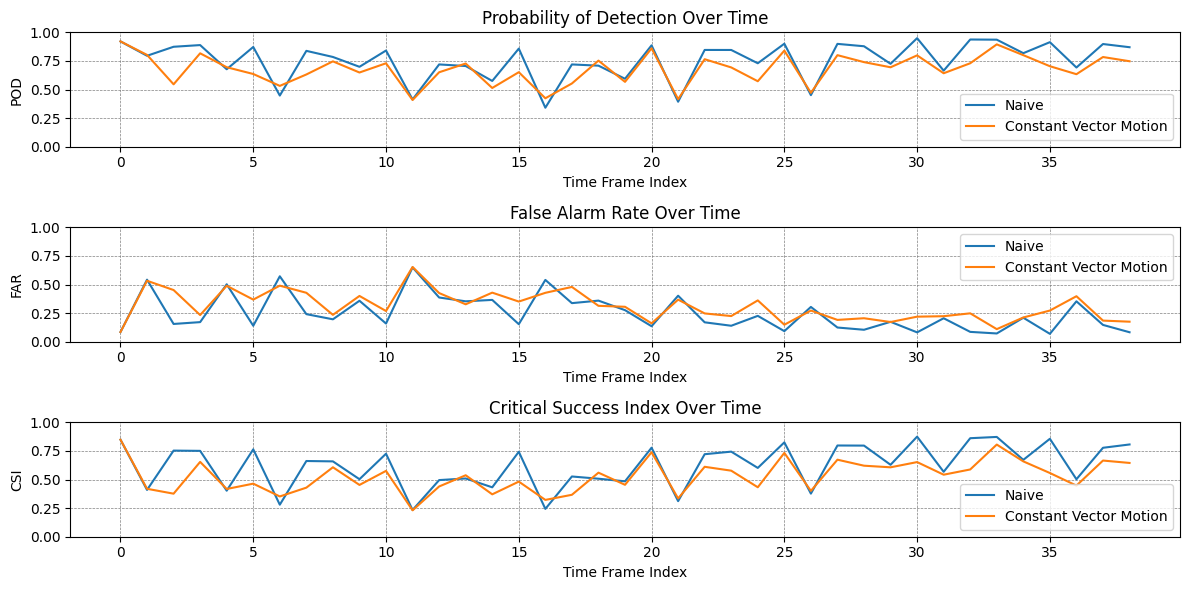

In [18]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()